https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import numpy as np
import re

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (8,5)

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics & model selection
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve

# Scipy
from scipy.stats import reciprocal

# Save model
import joblib
import pickle

In [2]:
train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.shape

(891, 12)

The training set has 891 rows and 12 columns.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Some features seems to have few missing values :

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Exploratory Data Analysis

## Survived

0 = No, 1 = Yes

In [6]:
eda_train = train.copy()

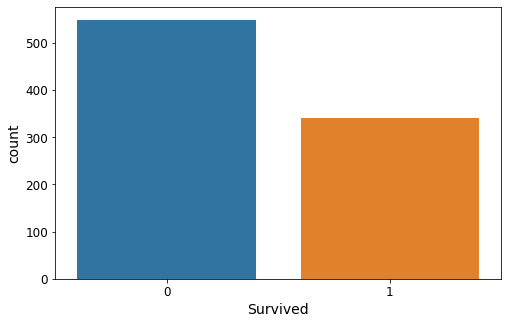

In [7]:
sns.countplot(x="Survived", data=eda_train)
plt.show()

In [8]:
eda_train["Survived"].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

38% of passengers survived, 62% of passengers died.

## Pclass

Ticket class. 1 = 1st, 2 = 2nd, 3 = 3rd

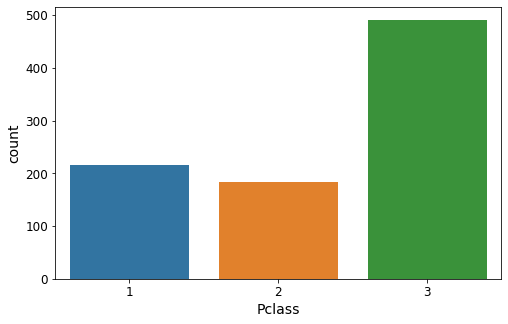

In [9]:
sns.countplot(x="Pclass", data=eda_train)
plt.show()

In [10]:
eda_train.groupby('Pclass')['Survived'].mean().sort_values(ascending=False)

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

## Name

I am going to create a new feature called `Status` to take into account the Mr., Mrs., and so on.

In [11]:
eda_train["Status"] = [re.findall("\,\s(.*?)\.", eda_train["Name"][i])[0] for i in range(len(eda_train))]
eda_train[["Name","Status"]].sample(n=5)

,Name,Status
572,"Flynn, Mr. John Irwin (""Irving"")",Mr
276,"Lindblom, Miss. Augusta Charlotta",Miss
220,"Sunderland, Mr. Victor Francis",Mr
507,"Bradley, Mr. George (""George Arthur Brayton"")",Mr
683,"Goodwin, Mr. Charles Edward",Mr


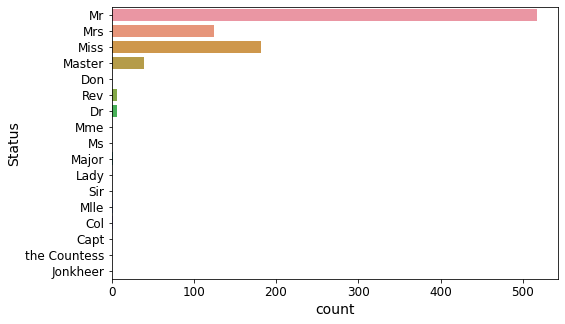

In [12]:
sns.countplot(y="Status", data=eda_train)
plt.show()

In [13]:
five_most_frequent_status = list(eda_train["Status"].value_counts().keys()[:5])
five_most_frequent_status

['Mr', 'Miss', 'Mrs', 'Master', 'Dr']

In [14]:
eda_train["Status_clean"] = [status if status in five_most_frequent_status else "Rare" for status in eda_train["Status"]]

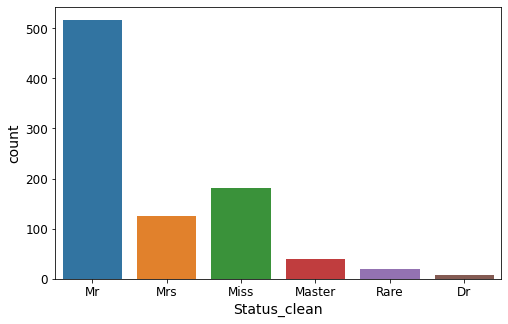

In [15]:
sns.countplot(data=eda_train, x="Status_clean")
plt.show()

In [16]:
eda_train.groupby('Status_clean')['Survived'].mean().sort_values(ascending=False)

Status_clean
Mrs       0.792000
Miss      0.697802
Master    0.575000
Rare      0.450000
Dr        0.428571
Mr        0.156673
Name: Survived, dtype: float64

## Sex

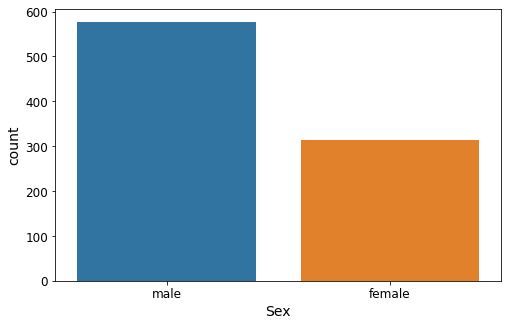

In [17]:
sns.countplot(data=eda_train, x="Sex")
plt.show()

In [18]:
train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

## SibSp

Number of siblings / spouses aboard the Titanic

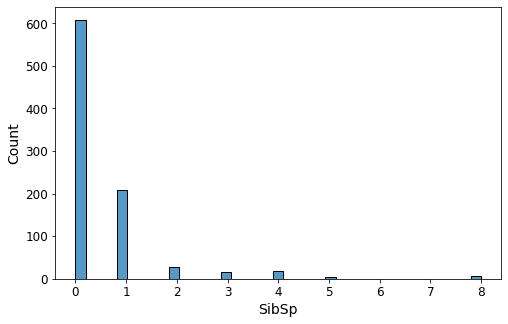

In [19]:
sns.histplot(eda_train['SibSp'], kde=False)
plt.show()

In [20]:
eda_train.groupby('SibSp')['Survived'].mean().sort_values(ascending=False)

SibSp
1    0.535885
2    0.464286
0    0.345395
3    0.250000
4    0.166667
8    0.000000
5    0.000000
Name: Survived, dtype: float64

## Age

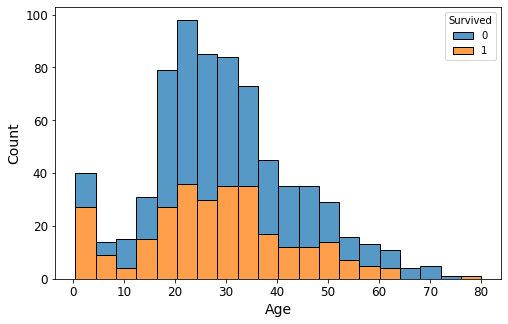

In [21]:
sns.histplot(data=eda_train, x="Age", hue="Survived", multiple="stack")
plt.show()

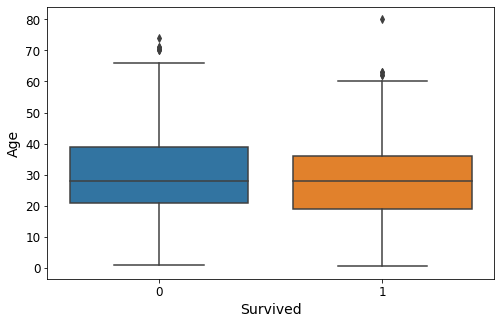

In [22]:
sns.boxplot(x="Survived", y="Age", data=eda_train)
plt.show()

In [23]:
eda_train.groupby('Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


## Parch 

Number of parents / children aboard the Titanic

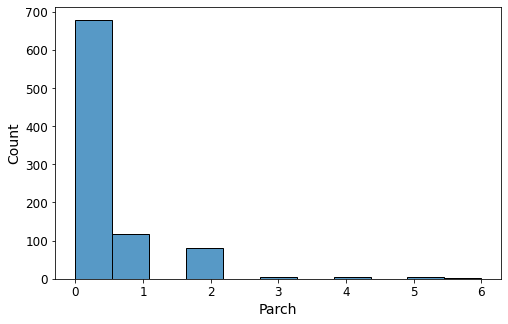

In [24]:
sns.histplot(eda_train['Parch'], kde=False)
plt.show()

In [25]:
eda_train.groupby('Parch')['Survived'].mean().sort_values(ascending=False)

Parch
3    0.600000
1    0.550847
2    0.500000
0    0.343658
5    0.200000
6    0.000000
4    0.000000
Name: Survived, dtype: float64

## Fare 

Passenger fare 

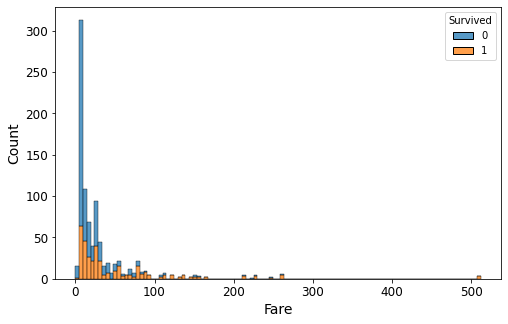

In [26]:
sns.histplot(data=eda_train, x="Fare", hue="Survived", multiple="stack")
plt.show()

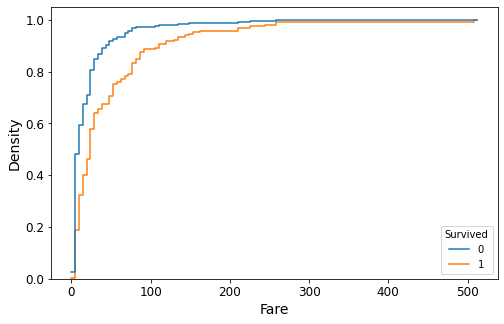

In [27]:
sns.histplot(
    data=eda_train, x="Fare", hue="Survived",
    cumulative=True, fill=False, element="step",
    stat="density", common_norm=False,
)
plt.show()

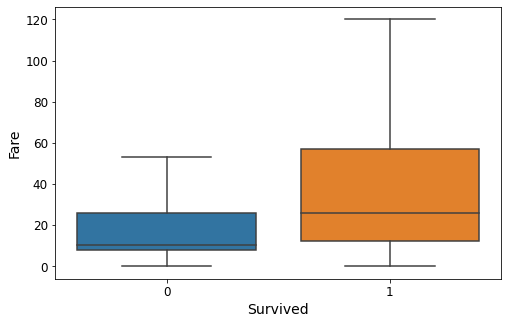

In [28]:
sns.boxplot(x="Survived", y="Fare", data=eda_train, showfliers=False)
plt.show()

In [29]:
eda_train.groupby('Survived')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


# Embarked

Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

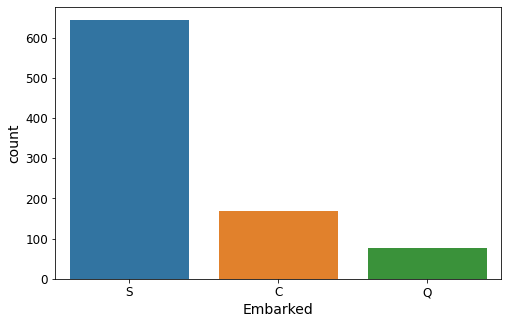

In [30]:
sns.countplot(x="Embarked", data=eda_train)
plt.show()

In [31]:
eda_train.groupby('Embarked')['Survived'].mean().sort_values(ascending=False)

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

## Sex * Embarked

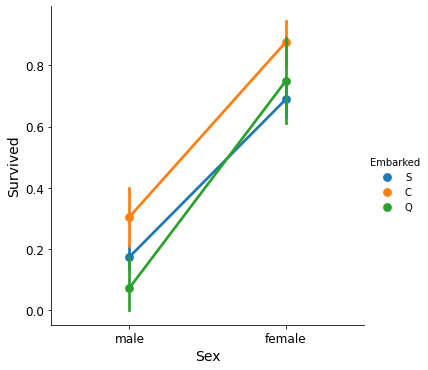

In [32]:
sns.catplot(data=eda_train, x="Sex", y="Survived", hue="Embarked", kind="point")
plt.show()

## Sex * Pclass

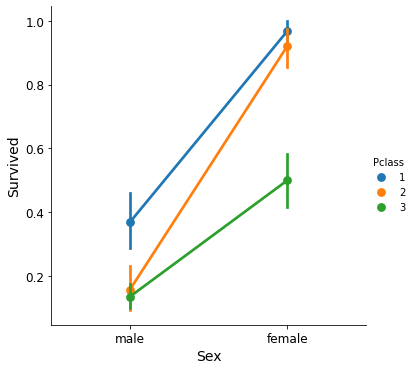

In [33]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="point", data=eda_train)
plt.show()

# Preprocessing

In [34]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
X_train = train.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
y_train = train['Survived']

In [36]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [37]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [38]:
num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Name', 'Sex', 'Embarked']

Let's build a pipeline to prepropressing numerical and categorical attributes :

In [39]:
name_ix = X_train.columns.get_loc("Name") # get the index of the Name column
five_most_frequent_status = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr'] # Reminder

class Status(BaseEstimator, TransformerMixin):
    
    def __init__(self, five_most_frequent_status):
        self.five_most_frequent_status = five_most_frequent_status 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        status = [re.findall("\,\s(.*?)\.", X[:, name_ix][i])[0] for i in range(len(X))]
        status_clean = [s if s in five_most_frequent_status else "Rare" for s in status]
        output = np.c_[X, status_clean]
        output_without_name = np.delete(output, name_ix, axis=1)
        return output_without_name

In [40]:
num_pipeline = Pipeline([
        ('num_imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy="most_frequent")),
    ('add_status', Status(five_most_frequent_status=five_most_frequent_status)),
    ('ohe', OneHotEncoder()),
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)

## Binary classifier

In [41]:
lr = LogisticRegression()
sgd_clf = SGDClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)

list_of_models = [lr, sgd_clf, rf_clf, knn_clf, svm_clf]
list_y_scores = []

for model in list_of_models :
    print('*'*100)
    print(model)
    print('-'*100)
    print("Accuracies with 5-folds cross validation :")
    print(cross_val_score(model, X_train_prepared, y_train, cv=5, scoring="accuracy"))
    print('-'*100)
    y_train_pred = cross_val_predict(model, X_train_prepared, y_train, cv=5)
    
    if model in [lr, rf_clf, knn_clf] :
        y_scores = cross_val_predict(model, X_train_prepared, y_train, cv=5, method="predict_proba")
        list_y_scores.append(y_scores)
    else:
        y_scores = cross_val_predict(model, X_train_prepared, y_train, cv=5, method="decision_function")
        list_y_scores.append(y_scores)
        
    print("Confusion matrix with 5-folds cross validation :")
    print(confusion_matrix(y_train, y_train_pred))
    print('-'*100)
    print("Precision : {:.2f}".format(precision_score(y_train, y_train_pred)))
    print("Recall : {:.2f}".format(recall_score(y_train, y_train_pred)))
    print("F1 : {:.2f}".format(f1_score(y_train, y_train_pred)))
    print('*'*100)

****************************************************************************************************
LogisticRegression()
----------------------------------------------------------------------------------------------------
Accuracies with 5-folds cross validation :
[0.83798883 0.81460674 0.80337079 0.79775281 0.85955056]
----------------------------------------------------------------------------------------------------
Confusion matrix with 5-folds cross validation :
[[478  71]
 [ 87 255]]
----------------------------------------------------------------------------------------------------
Precision : 0.78
Recall : 0.75
F1 : 0.76
****************************************************************************************************
****************************************************************************************************
SGDClassifier(random_state=42)
----------------------------------------------------------------------------------------------------
Accuracies with 5-folds cros

## ROC curves

In [42]:
y_scores_logistic_regression = list_y_scores[0]
y_scores_sgd_clf = list_y_scores[1]
y_scores_rf_clf = list_y_scores[2]
y_scores_knn_clf = list_y_scores[3]
y_scores_svm_clf = list_y_scores[4]

In [43]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, y_scores_logistic_regression[:, 1])
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd_clf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf_clf[:, 1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_scores_knn_clf[:, 1])
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm_clf)

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=1.5, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True) 

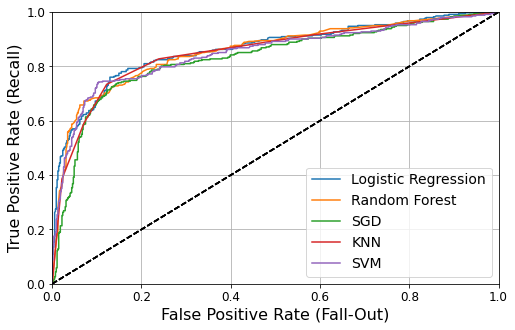

In [45]:
plot_roc_curve(fpr_lr, tpr_lr, "Logistic Regression")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plot_roc_curve(fpr_sgd, tpr_sgd, "SGD")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## Fine tune logistic regression

In [46]:
param_distribs = {
        'penalty': ['l1', 'l2'],
        'C': reciprocal(0.01, 10),
        'solver': ['liblinear'],
        'class_weight' : ['balanced', None],
        'fit_intercept' : [True, False],
    }

lr = LogisticRegression()
rnd_search = RandomizedSearchCV(lr, param_distributions=param_distribs,
                                n_iter=500, cv=5, scoring='accuracy',
                                verbose=3, random_state=42)

rnd_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.782, total=   0.0s
[CV] C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.770, total=   0.0s
[CV] C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.13292918943162163, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.1329291

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.011527987128232399, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.011527987128232399, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.831, total=   0.0s
[CV] C=6.541210527692733, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=6.541210527692733, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.838, total=   0.0s
[CV] C=6.541210527692733, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=6.541210527692733, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=6.541210527692733, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=6.541210527692733, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=6.541210527692733, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=6.5412105

[CV]  C=0.04928122297695502, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.04928122297695502, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.04928122297695502, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.04928122297695502, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.04928122297695502, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.04928122297695502, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.04928122297695502, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.843, total=   0.0s
[CV] C=0.023233503515390108, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.023233503515390108, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, sc

[CV] C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.809, total=   0.0s
[CV] C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.809, total=   0.0s
[CV] C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.3651764648751757, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.843, total=   0.0s
[CV] C=0.14656553886225332, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.14656

[CV] C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.838, total=   0.0s
[CV] C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=6.010389754773887, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=6.010389754773887, class_

[CV]  C=0.3029610442821248, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.3029610442821248, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.3029610442821248, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.837, total=   0.0s
[CV] C=0.0215115875518196, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.0215115875518196, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.777, total=   0.0s
[CV] C=0.0215115875518196, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.0215115875518196, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.0215115875518196, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.0215115875518196, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792

[CV]  C=0.1776355330710272, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.1776355330710272, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.1776355330710272, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.843, total=   0.0s
[CV] C=2.6443593078398626, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=2.6443593078398626, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.832, total=   0.0s
[CV] C=2.6443593078398626, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=2.6443593078398626, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.820, total=   0.0s
[CV] C=2.6443593078398626, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=2.6443593078398626, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.803, total=   0

[CV]  C=0.01290211302456715, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.775, total=   0.0s
[CV] C=0.01290211302456715, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.01290211302456715, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.770, total=   0.0s
[CV] C=0.01290211302456715, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.01290211302456715, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.17104525858990532, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.17104525858990532, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.816, total=   0.0s
[CV] C=0.17104525858990532, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.17104525858990532, class_weight=balanced, fit_intercept=True, pen

[CV] C=3.2055863990707496, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=3.2055863990707496, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.876, total=   0.0s
[CV] C=1.2230336899557772, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=1.2230336899557772, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.827, total=   0.0s
[CV] C=1.2230336899557772, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=1.2230336899557772, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.787, total=   0.0s
[CV] C=1.2230336899557772, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=1.2230336899557772, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=1.2230336899557772, class_weight=balanced, fit_intercept=False, penalty=l2, solver=

[CV]  C=0.019024283247489577, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.019024283247489577, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.019024283247489577, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.753, total=   0.0s
[CV] C=0.019024283247489577, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.019024283247489577, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=4.445381415737548, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=4.445381415737548, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.810, total=   0.0s
[CV] C=4.445381415737548, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=4.445381415737548, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, s

[CV]  C=0.9393743056153981, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.9393743056153981, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.9393743056153981, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.9393743056153981, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.9393743056153981, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.9393743056153981, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.9393743056153981, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.848, total=   0.0s
[CV] C=0.336079661042078, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.336079661042078, class_weight=None, fit_intercept=True, penalty=l2, solver=l

[CV]  C=4.471796861411276, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.820, total=   0.0s
[CV] C=4.471796861411276, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=4.471796861411276, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=4.471796861411276, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=4.471796861411276, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=4.471796861411276, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=4.471796861411276, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.876, total=   0.0s
[CV] C=6.094747077200002, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=6.094747077200002, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.810, total=   

[CV]  C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.816, total=   0.0s
[CV] C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.815, total=   0.0s
[CV] C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.6684217902257081, class_weight=balanced, fit_intercept=True, penalty=l1, solve

[CV] C=0.01281819344392312, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.01281819344392312, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=8.821098364250346, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=8.821098364250346, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.832, total=   0.0s
[CV] C=8.821098364250346, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=8.821098364250346, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=8.821098364250346, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=8.821098364250346, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=8.821098364250346, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=8.82

[CV]  C=1.2243980190472084, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=1.2243980190472084, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.2243980190472084, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.854, total=   0.0s
[CV] C=5.567255883122282, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=5.567255883122282, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.816, total=   0.0s
[CV] C=5.567255883122282, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=5.567255883122282, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.775, total=   0.0s
[CV] C=5.567255883122282, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=5.567255883122282, class_weight=balanced, fit_intercept=False, penalty=l2, solve

[CV]  C=0.03357305095994098, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.775, total=   0.0s
[CV] C=0.03357305095994098, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.03357305095994098, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.831, total=   0.0s
[CV] C=0.2984335364446721, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.2984335364446721, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.821, total=   0.0s
[CV] C=0.2984335364446721, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.2984335364446721, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.2984335364446721, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.2984335364446721, class_weight=balanced, fit_intercept=False, penalty=l1, solve

[CV]  C=2.7140167909720856, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=2.7140167909720856, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=2.7140167909720856, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.854, total=   0.0s
[CV] C=0.1439819043568815, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.1439819043568815, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.793, total=   0.0s
[CV] C=0.1439819043568815, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.1439819043568815, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.1439819043568815, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.1439819043568815, class_weight=balanced, fit_intercept=False, penalty=l2,

[CV]  C=9.365164840715295, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=9.365164840715295, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=9.365164840715295, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=9.365164840715295, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=9.365164840715295, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.876, total=   0.0s
[CV] C=0.05624052260681025, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.05624052260681025, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.788, total=   0.0s
[CV] C=0.05624052260681025, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.05624052260681025, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.809, to

[CV]  C=7.50973289999112, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.854, total=   0.0s
[CV] C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.816, total=   0.0s
[CV] C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.09076970265355107, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803,

[CV]  C=3.986631701572257, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=3.986631701572257, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=3.986631701572257, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=3.986631701572257, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=3.986631701572257, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=3.986631701572257, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=3.986631701572257, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.876, total=   0.0s
[CV] C=1.2673815903184187, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.2673815903184187, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.838, total=   0.0s
[CV

[CV]  C=2.145066437415384, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=2.145066437415384, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=2.145066437415384, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.876, total=   0.0s
[CV] C=0.055740705768542106, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.055740705768542106, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.793, total=   0.0s
[CV] C=0.055740705768542106, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.055740705768542106, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.055740705768542106, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.055740705768542106, class_weight=balanced, fit_intercept=True, penalty=l2, solver=l

[CV]  C=9.525644914201472, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=9.525644914201472, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=9.525644914201472, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.854, total=   0.0s
[CV] C=1.2196448023200597, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.2196448023200597, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.816, total=   0.0s
[CV] C=1.2196448023200597, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.2196448023200597, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=1.2196448023200597, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.2196448023200597, class_weight=balanced, fit_intercept=False, penalty=l1,

[CV]  C=0.12051338512695743, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.809, total=   0.0s
[CV] C=0.12051338512695743, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.12051338512695743, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.781, total=   0.0s
[CV] C=0.12051338512695743, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.12051338512695743, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.12051338512695743, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.12051338512695743, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.820, total=   0.0s
[CV] C=1.2430401086355436, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.2430401086355436, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, s

[CV]  C=0.27612787175114906, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.27612787175114906, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.27612787175114906, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.848, total=   0.0s
[CV] C=0.6058877139402058, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.6058877139402058, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.827, total=   0.0s
[CV] C=0.6058877139402058, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.6058877139402058, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.6058877139402058, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.6058877139402058, class_weight=balanced, fit_intercept=True, penalty=l2, so

[CV]  C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.821, total=   0.0s
[CV] C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.820, total=   0.0s
[CV] C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=8.015327949118781, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.876, total=   0

[CV]  C=3.359496902928335, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.854, total=   0.0s
[CV] C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.821, total=   0.0s
[CV] C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.809, total=   0.0s
[CV] C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.23845545870139886, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, sco

[CV]  C=0.024335775756765696, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.024335775756765696, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.024335775756765696, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.024335775756765696, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.024335775756765696, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.764, total=   0.0s
[CV] C=0.024335775756765696, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.024335775756765696, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.013120078077267536, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.013120078077267536, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinea

[CV]  C=1.3805392471755742, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=1.3805392471755742, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.3805392471755742, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.854, total=   0.0s
[CV] C=1.7735714781872853, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.7735714781872853, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.838, total=   0.0s
[CV] C=1.7735714781872853, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.7735714781872853, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=1.7735714781872853, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.7735714781872853, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803

[CV]  C=4.999679802397119, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=4.999679802397119, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=4.999679802397119, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.876, total=   0.0s
[CV] C=0.11702810634779676, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.11702810634779676, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.782, total=   0.0s
[CV] C=0.11702810634779676, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.11702810634779676, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.11702810634779676, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.11702810634779676, class_weight=balanced, fit_intercept=False, penalty=l1, solve

[CV]  C=2.8262866872541346, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.854, total=   0.0s
[CV] C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.838, total=   0.0s
[CV] C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.4746477409966832, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total

[CV]  C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.810, total=   0.0s
[CV] C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.770, total=   0.0s
[CV] C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=9.329979664603119, class_weight=balanced, fit_intercept=False, penalty=l2, solve

[CV]  C=3.353407491978029, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=3.353407491978029, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=3.353407491978029, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.876, total=   0.0s
[CV] C=1.7844557141627633, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.7844557141627633, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.832, total=   0.0s
[CV] C=1.7844557141627633, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.7844557141627633, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.820, total=   0.0s
[CV] C=1.7844557141627633, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.7844557141627633, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.803, total= 

[CV]  C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.838, total=   0.0s
[CV] C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=1.5547029063412448, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear, score=0.876, t

[CV]  C=2.06845435557871, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.781, total=   0.0s
[CV] C=2.06845435557871, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=2.06845435557871, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.815, total=   0.0s
[CV] C=2.06845435557871, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=2.06845435557871, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=2.06845435557871, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=2.06845435557871, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.854, total=   0.0s
[CV] C=1.2073837693216016, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.2073837693216016, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0

[CV]  C=5.7049463784557375, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.854, total=   0.0s
[CV] C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.838, total=   0.0s
[CV] C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=1.3234754903375765, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.798, total

[CV]  C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.816, total=   0.0s
[CV] C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.775, total=   0.0s
[CV] C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.815, total=   0.0s
[CV] C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=2.561889217260502, class_weight=balanced, fit_intercept=False, penalty=l1, solve

[CV]  C=0.03575926751784726, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.015893861790374164, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.015893861790374164, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.777, total=   0.0s
[CV] C=0.015893861790374164, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.015893861790374164, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.015893861790374164, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.015893861790374164, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.764, total=   0.0s
[CV] C=0.015893861790374164, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.015893861790374164, class_weight=balanced, fit_intercept=True, 

[CV]  C=0.167476349552329, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.167476349552329, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.167476349552329, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.167476349552329, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.167476349552329, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.167476349552329, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.167476349552329, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.04934286811215813, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.04934286811215813, class_weight=balanced, fit_intercept=True, penalty=l1, solver=lib

[CV]  C=0.018229512084268366, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.753, total=   0.0s
[CV] C=0.018229512084268366, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.018229512084268366, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.04203961842138755, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.04203961842138755, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.793, total=   0.0s
[CV] C=0.04203961842138755, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.04203961842138755, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.04203961842138755, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.04203961842138755, class_weight=balanced, fit_intercept=False, penalty=l1,

[CV]  C=4.030917667716686, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.820, total=   0.0s
[CV] C=4.030917667716686, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=4.030917667716686, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=4.030917667716686, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=4.030917667716686, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=4.030917667716686, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=4.030917667716686, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.876, total=   0.0s
[CV] C=0.258938339152605, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.258938339152605, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.827, total=   0.0s
[CV] 

[CV]  C=0.06639963041506416, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.770, total=   0.0s
[CV] C=0.06639963041506416, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.06639963041506416, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.775, total=   0.0s
[CV] C=0.06639963041506416, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.06639963041506416, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.31073822593697836, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.31073822593697836, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.827, total=   0.0s
[CV] C=0.31073822593697836, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.31073822593697836, class_weight=None, fit_intercept=True, penalty=l1, solver=libli

[CV]  C=0.6779755015182094, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.6779755015182094, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.6779755015182094, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.6779755015182094, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.6779755015182094, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.854, total=   0.0s
[CV] C=0.9795204244055944, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.9795204244055944, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.832, total=   0.0s
[CV] C=0.9795204244055944, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.9795204244055944, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.820, t

[CV]  C=2.5017714778000526, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=2.5017714778000526, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=2.5017714778000526, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.876, total=   0.0s
[CV] C=0.010369586905113849, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.010369586905113849, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.642, total=   0.0s
[CV] C=0.010369586905113849, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.010369586905113849, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.618, total=   0.0s
[CV] C=0.010369586905113849, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.010369586905113849, class_weight=None, fit_intercept=True, penalty=l1, solver=liblinear, score=0.618

[CV]  C=5.966847691102617, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.770, total=   0.0s
[CV] C=5.966847691102617, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=5.966847691102617, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.815, total=   0.1s
[CV] C=5.966847691102617, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=5.966847691102617, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=5.966847691102617, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=5.966847691102617, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.854, total=   0.0s
[CV] C=0.2628030215939252, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.2628030215939252, class_weight=balanced, fit_intercept=False, penalty=l1, sol

[CV]  C=1.227061493322397, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=1.227061493322397, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=1.227061493322397, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.871, total=   0.0s
[CV] C=0.1634768832196295, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.1634768832196295, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.816, total=   0.0s
[CV] C=0.1634768832196295, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.1634768832196295, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.1634768832196295, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.1634768832196295, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear,

[CV]  C=4.178605220965294, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=4.178605220965294, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=4.178605220965294, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.854, total=   0.0s
[CV] C=0.01884074212298776, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.01884074212298776, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.793, total=   0.0s
[CV] C=0.01884074212298776, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.01884074212298776, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.01884074212298776, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.01884074212298776, class_weight=balanced, fit_intercept=True, penalty=l2, so

[CV]  C=2.285783235914814, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=2.285783235914814, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=2.285783235914814, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.798, total=   0.0s
[CV] C=2.285783235914814, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=2.285783235914814, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.854, total=   0.0s
[CV] C=8.850983787415496, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=8.850983787415496, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.810, total=   0.0s
[CV] C=8.850983787415496, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=8.850983787415496, class_weight=balanced, fit_intercept=False, penalty=l2, solve

[CV]  C=7.444075838128254, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.876, total=   0.0s
[CV] C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.777, total=   0.0s
[CV] C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.764, total=   0.0s
[CV] C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.014911729937656494, class_weight=balanced, fit_intercept=True, penal

[CV]  C=0.4493369280060231, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.4493369280060231, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.4493369280060231, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.4493369280060231, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.4493369280060231, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.4493369280060231, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.4493369280060231, class_weight=balanced, fit_intercept=False, penalty=l2, solver=liblinear, score=0.843, total=   0.0s
[CV] C=0.05727265046691271, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=0.05727265046691271, class_weight=None, fit_intercept=False, penalty=l1, so

[CV]  C=0.054432288875490634, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.054432288875490634, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.054432288875490634, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.831, total=   0.0s
[CV] C=1.3337945242748988, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.3337945242748988, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.816, total=   0.0s
[CV] C=1.3337945242748988, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.3337945242748988, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=1.3337945242748988, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=1.3337945242748988, class_weight=balanced, fit_intercept=True, penalty=l1,

[CV]  C=0.7092196422398915, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.7092196422398915, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.7092196422398915, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.798, total=   0.0s
[CV] C=0.7092196422398915, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.7092196422398915, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=0.7092196422398915, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.7092196422398915, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.837, total=   0.0s
[CV] C=0.02226032856799669, class_weight=None, fit_intercept=False, penalty=l2, solver=liblinear 
[CV]  C=0.02226032856799669, class_weight=None, fit_intercept=False, penalty=l2, solver=li

[CV]  C=0.0159239866349049, class_weight=None, fit_intercept=False, penalty=l1, solver=liblinear, score=0.713, total=   0.0s
[CV] C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.816, total=   0.0s
[CV] C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.014919744354026035, class_weight=None, fit_intercept=True, penalty=l2, solver=liblinear, score=

[CV]  C=0.18990828276404473, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=0.18990828276404473, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.18990828276404473, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.820, total=   0.0s
[CV] C=0.3811292573592122, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.3811292573592122, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.816, total=   0.0s
[CV] C=0.3811292573592122, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.3811292573592122, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear, score=0.787, total=   0.0s
[CV] C=0.3811292573592122, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear 
[CV]  C=0.3811292573592122, class_weight=balanced, fit_intercept=True, penalty=l1, so

[CV]  C=4.8116896843559624, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.792, total=   0.0s
[CV] C=4.8116896843559624, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear 
[CV]  C=4.8116896843559624, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear, score=0.854, total=   0.0s
[CV] C=0.03990960511143544, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.03990960511143544, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.793, total=   0.0s
[CV] C=0.03990960511143544, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.03990960511143544, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear, score=0.809, total=   0.0s
[CV] C=0.03990960511143544, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear 
[CV]  C=0.03990960511143544, class_weight=balanced, fit_intercept=True, penalty=

[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   28.4s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=500,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6ba2d7b7c0>,
                                        'class_weight': ['balanced', None],
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   random_state=42, scoring='accuracy', verbose=3)

In [47]:
rnd_search.best_score_

0.8282719226664993

In [48]:
rnd_search.best_params_

{'C': 2.0736445177905023,
 'class_weight': None,
 'fit_intercept': False,
 'penalty': 'l2',
 'solver': 'liblinear'}

## Evaluate on test set

In [49]:
final_model = rnd_search.best_estimator_
final_model

LogisticRegression(C=2.0736445177905023, fit_intercept=False,
                   solver='liblinear')

In [50]:
#final_model = joblib.load("my_model.pkl")

In [55]:
with open('titanic-model.bin', 'wb') as f_out: # wb = write, binary
    pickle.dump((full_pipeline, final_model), f_out)

In [52]:
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv('gender_submission.csv')
test["Survived"] = gender_submission["Survived"]

In [53]:
X_test = test.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
y_test = test['Survived']
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

In [54]:
print("* Confusion matrix :")
print(confusion_matrix(y_test, final_predictions))
print("* Accuracy score : {:.2f}".format(accuracy_score(y_test, final_predictions)))
print("* Precision : {:.2f}".format(precision_score(y_test, final_predictions)))
print("* Recall : {:.2f}".format(recall_score(y_test, final_predictions)))
print("* F1 : {:.2f}".format(f1_score(y_test, final_predictions)))

* Confusion matrix :
[[241  25]
 [  9 143]]
* Accuracy score : 0.92
* Precision : 0.85
* Recall : 0.94
* F1 : 0.89


In [62]:
with open('titanic-model.bin', 'rb') as f_in:
    pipeline, model = pickle.load(f_in)

In [107]:
def predict_single(passenger, pipeline, model):
    X = pipeline.transform(passenger)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred[0]

In [154]:
passenger = dict(X_train.iloc[0, :])
passenger

{'Pclass': 3,
 'Name': 'Braund, Mr. Owen Harris',
 'Sex': 'male',
 'Age': 22.0,
 'SibSp': 1,
 'Parch': 0,
 'Fare': 7.25,
 'Embarked': 'S'}

In [153]:
passenger = pd.DataFrame.from_dict(data=passenger, orient='index').T

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.25,S


In [134]:
p = pd.DataFrame(X_train.iloc[0, :]).T
p

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.25,S


In [129]:
X = pipeline.transform(p)
X

ValueError: Expected 2D array, got scalar array instead:
array={'Pclass': 3, 'Name': 'Braund, Mr. Owen Harris', 'Sex': 'male', 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Fare': 7.25, 'Embarked': 'S'}.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [130]:
predict_single(passenger, pipeline, model)

0.05714818987116563

In [ ]:
def predict():
    passenger = request.get_json()
    prediction = predict_single(customer, dv, model)
    churn = prediction >= 0.5
   
    result = {
        'churn_probability': float(prediction),
        'churn': bool(churn)}
 
    return jsonify(result)

In [155]:
name_ix

1